# For plotting statistics from the lab analysis only

This notebook should be self contained, you may need to change the `DATA_PATH` if running locally so it can find the data tables.

In [1]:
import csv
import sys

import os
import os.path as osp

import glob

import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# evaluation metrics
from sklearn.metrics import r2_score

from plot_utils import *

IN_COLAB = 'google.colab' in sys.modules

In [2]:
'''
root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
jpeg_files = glob.glob(root_path + '*.jpg')
jpeg_files.sort()
# Should equal 40
print(len(jpeg_files)) 

csvfile = 'lab-v100-originals-files.csv'

with open(csvfile, 'w') as f:
    csvwriter = csv.writer(f, delimiter=',')#, #escapechar='', quoting=csv.QUOTE_NONE)
    for i in range(len(jpeg_files)):
        csvwriter.writerow([jpeg_files[i].split('/')[-1]])
'''

"\nroot_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'\njpeg_files = glob.glob(root_path + '*.jpg')\njpeg_files.sort()\n# Should equal 40\nprint(len(jpeg_files)) \n\ncsvfile = 'lab-v100-originals-files.csv'\n\nwith open(csvfile, 'w') as f:\n    csvwriter = csv.writer(f, delimiter=',')#, #escapechar='', quoting=csv.QUOTE_NONE)\n    for i in range(len(jpeg_files)):\n        csvwriter.writerow([jpeg_files[i].split('/')[-1]])\n"

The list of files is now stored in a csv file in this repo for portability

In [3]:
jpeg_files = []

csvfile = 'lab-v100-originals-files.csv'
with open(csvfile, 'r') as f:
    spamreader = csv.reader(f, delimiter=',', quotechar='|')
    for row in spamreader:
        jpeg_files.append(row[0])
print(len(jpeg_files))        

40


In [7]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
else:
    #DATA_PATH = r'/scratch/gallowaa/cciw/Data'
    DATA_PATH = r'/media/angus/cciw/Data'

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [8]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

BIOMASS_IDX = 0
COUNT_IDX = 1
PRED_COUNT_IDX = 2

In [9]:
lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count

names = ['16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm']
sieves = np.array([16, 14, 12.5, 10, 8, 6.3, 4, 2])

for i in range(len(jpeg_files)):
    
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('Lab_')[1]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
    lab_targets[i, COUNT_IDX] = row['Count'].values
    
    size_dist = np.zeros(len(names))
    for j in range(len(names)):
        size_dist[j] = row[names[j]].values
        
    lab_targets[i, PRED_COUNT_IDX] = (lab_targets[i, BIOMASS_IDX] * size_dist * 2 / sieves).sum()

lab_targets[np.isnan(lab_targets)] = 0

biomass = lab_targets[:, BIOMASS_IDX] / lab_targets[:, BIOMASS_IDX].max()
a_count = lab_targets[:, COUNT_IDX] / lab_targets[:, COUNT_IDX].max()
p_count = lab_targets[:, PRED_COUNT_IDX] / lab_targets[:, PRED_COUNT_IDX].max()

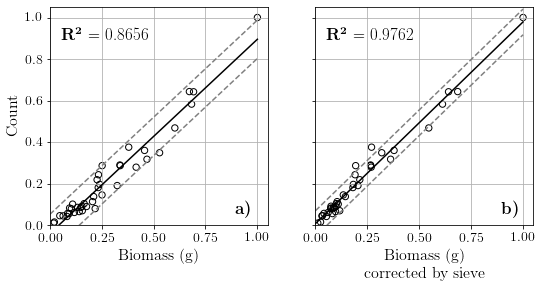

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(biomass, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].set_xlabel('Biomass (g)', fontsize=fontsize)

ax[1].scatter(p_count, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_xlabel('Biomass (g) \n corrected by sieve', fontsize=fontsize)

draw_lines(ax[0], biomass, a_count)
draw_lines(ax[1], p_count, a_count)

draw_rsquared(ax[0], a_count, biomass, fontsize)
draw_rsquared(ax[1], a_count, p_count, fontsize)

draw_sublabel(ax[0], r'\textbf{a)}', fontsize)
draw_sublabel(ax[1], r'\textbf{b)}', fontsize)

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

In [ ]:
#fname = 'lab_count_from_biomass'
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')

# Plot biomass from live coverage

In [ ]:
'''
root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-v111-originals/JPEGImages/'
#root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Validation-v101-originals/JPEGImages/'

jpeg_files = glob.glob(root_path + '*.jpg')
jpeg_files.sort()

# Should equal 121
print(len(jpeg_files))

csvfile = 'train-v111-originals-files.csv'

with open(csvfile, 'w') as f:
    csvwriter = csv.writer(f, delimiter=',')#, #escapechar='', quoting=csv.QUOTE_NONE)
    for i in range(len(jpeg_files)):
        csvwriter.writerow([jpeg_files[i].split('/')[-1]])
'''        

In [11]:
jpeg_files = []

csvfile = 'train-v111-originals-files.csv'
with open(csvfile, 'r') as f:
    spamreader = csv.reader(f, delimiter=',', quotechar='|')
    for row in spamreader:
        jpeg_files.append(row[0])
print(len(jpeg_files))        

121


In [12]:
lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count, 2 = live coverage

LIVE_COVERAGE = 2

for i in range(len(jpeg_files)):
    
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('GLNI_')[1]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
    lab_targets[i, COUNT_IDX] = row['Count'].values
    lab_targets[i, LIVE_COVERAGE] = row['Live Coverage'].values

lab_targets[np.isnan(lab_targets)] = 0
biomass = lab_targets[:, BIOMASS_IDX] / lab_targets[:, BIOMASS_IDX].max()
count = lab_targets[:, COUNT_IDX] / lab_targets[:, COUNT_IDX].max()
live_coverage = lab_targets[:, LIVE_COVERAGE] / lab_targets[:, LIVE_COVERAGE].max()

In [13]:
def pretty_axis(ax, fontsize, xlim, ylim):
    ax.set_ylim(0, ylim)
    ax.set_xlim(0, xlim)
    ax.grid()
    #ax.set_aspect('equal')
    ax.tick_params(labelsize=fontsize - 2)

In [14]:
def draw_lines(ax, x, y, xlim):

    x_ = np.linspace(0, xlim)

    A = np.vstack([x, np.ones(len(x))]).T
    (m, c), res, r, s = np.linalg.lstsq(A, y, rcond=-1)
    std = np.sqrt(res[0] / len(y))

    ax.plot(x_, m * x_ + c, 'k', linestyle='-')
    ax.plot(x_, m * x_ + c + 1.96 * std, '--', color='gray')
    ax.plot(x_, m * x_ + c - 1.96 * std, '--', color='gray')

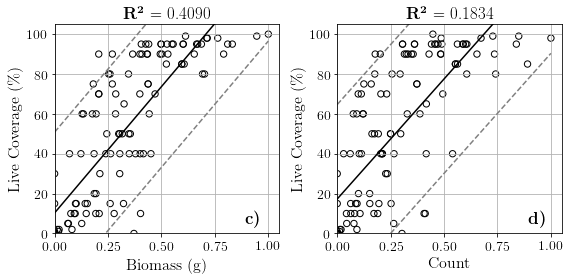

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
ax[0].scatter(biomass, live_coverage*100, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Live Coverage (\%)', fontsize=fontsize)
ax[0].set_xlabel('Biomass (g)', fontsize=fontsize)
ax[1].scatter(count, live_coverage*100, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_ylabel('Live Coverage (\%)', fontsize=fontsize)
ax[1].set_xlabel('Count', fontsize=fontsize)
draw_lines(ax[0], biomass, live_coverage*100, 1)
draw_lines(ax[1], count, live_coverage*100, 1)
ax[0].set_title(r'$\mathbf{R^2}$ = %.4f' % r2_score(live_coverage, biomass), fontsize=fontsize + 1)
ax[1].set_title(r'$\mathbf{R^2}$ = %.4f' % r2_score(live_coverage, count), fontsize=fontsize + 1)
draw_sublabel(ax[0], r'\textbf{c)}', fontsize)
draw_sublabel(ax[1], r'\textbf{d)}', fontsize)
pretty_axis(ax[0], fontsize, 1.05, 105)
pretty_axis(ax[1], fontsize, 1.05, 105)
plt.tight_layout()
fname = 'train_v111_predict_live_coverage_from_biomass_and_count_cd'
#fig.savefig(fname + '.eps', format='eps')

In [16]:
# This is the cell that yields negative r2_score

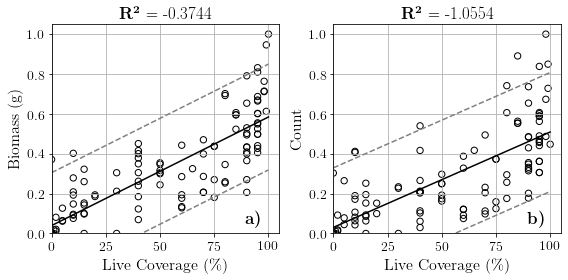

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
ax[0].scatter(live_coverage * 100, biomass, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_xlabel('Live Coverage (\%)', fontsize=fontsize)
ax[0].set_ylabel('Biomass (g)', fontsize=fontsize)
ax[1].scatter(live_coverage * 100, count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_ylabel('Count', fontsize=fontsize)
ax[1].set_xlabel('Live Coverage (\%)', fontsize=fontsize)
draw_lines(ax[0], live_coverage*100, biomass, 100)
draw_lines(ax[1], live_coverage*100, count, 100)
ax[0].set_title(r'$\mathbf{R^2}$ = %.4f' % r2_score(biomass, live_coverage), fontsize=fontsize + 1)
ax[1].set_title(r'$\mathbf{R^2}$ = %.4f' % r2_score(count, live_coverage), fontsize=fontsize + 1)
draw_sublabel(ax[0], r'\textbf{a)}', fontsize)
draw_sublabel(ax[1], r'\textbf{b)}', fontsize)
pretty_axis(ax[0], fontsize, 105, 1.05)
pretty_axis(ax[1], fontsize, 105, 1.05)
plt.tight_layout()
fname = 'train_v111_predict_biomass_and_count_from_live_coverage_ab'
#fig.savefig(fname + '.eps', format='eps')